## Hybrid Ice Stream Split

Trying to change the bed geometry to slope in both directions, and include accumulation zone instead of boundary condition.

Import firedrake and set initial conditions.

In [1]:
import firedrake
import icepack
import matplotlib.pyplot as plt
import numpy as np

Lx = 100e3
nx = 72

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


Set up function spaces for the scalars (Q) and vectors (V) for the 2D mesh.

In [2]:
Q = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="R", vdegree=0)
V = firedrake.FunctionSpace(mesh, "CG", 2, vfamily="GL", vdegree=2)

Import a couple constant values from icepack.

In [3]:
from icepack.constants import(
    ice_density as rho_ice,           # ρ_I | 9.21e-19
    water_density as rho_water,       # ρ_W | 1.03e-18
    weertman_sliding_law as weertman, # m   | 3.0
    gravity as g,                     # g   | 9.77e15
)

Set up spatial coordinates and parameterize bed and surface geometry.

In [4]:
from firedrake import max_value, min_value
from firedrake import conditional, eq, ne, le, ge, lt, gt

x, z = firedrake.SpatialCoordinate(mesh)

b_in, b_out = 100, -500
b_in2, b_out2 = 0, -100
# base_x_r = b_in - (b_in - b_out) * x/Lx
# base_x_l = b_out - (b_out - b_in) * x/Lx
# b = firedrake.interpolate(min_value(base_x_l, base_x_r), Q) # Scalar function space
base_x = b_in - (b_in - b_out) * x/Lx
# base_x = (b_in - (b_in - b_out) * x/Lx) * (1-x/Lx) + (b_in2 - (b_in2 - b_out2) * x/Lx) * (x/Lx)
b = firedrake.interpolate(base_x, Q)

s_in, s_out = 850, 0
# surface_x_r = s_in - (s_in - s_out) * x /Lx
# surface_x_l = s_out - (s_out - s_in) * x /Lx
# s0 = firedrake.interpolate(min_value(surface_x_l, surface_x_r), Q) # Scalar function space
surface_x = s_in - (s_in - s_out) * x/Lx
s0 = firedrake.interpolate(surface_x, Q)

height_x = s0 - b
h0 = firedrake.interpolate(height_x, Q) # Scalar function space

h_in = s_in - b_in
surface_slope = (s_out - s_in) / Lx # δs_δx
tau_D = -rho_ice * g * h_in * surface_slope # what value is tau_D representing?

Check what the profile looks like.

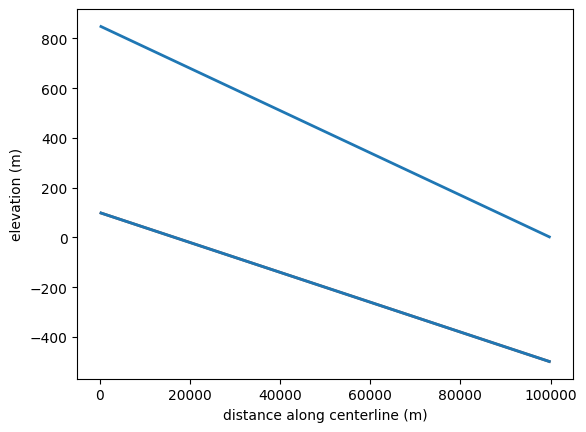

In [5]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb0 = firedrake.interpolate(s0-h0, Q)
firedrake.plot(icepack.depth_average(zb0), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s0), edgecolor="tab:blue", axes = axes);

Estimate intial velocities, increasing exponentially towards the terminus.

In [6]:
u_in, u_out = 20, 2400
velocity_x_r = u_in + (u_out - u_in) * (x / Lx)**2
velocity_x_l = -(u_in + (u_out - u_in) * ((Lx - x) / Lx)**2)

u0_l = firedrake.interpolate(velocity_x_l, V) # Vector function space
u0_r = firedrake.interpolate(velocity_x_r, V) # Vector function space

# u0 = firedrake.interpolate(velocity_x_l + velocity_x_r, V)
u0 = firedrake.interpolate(velocity_x_r,V)

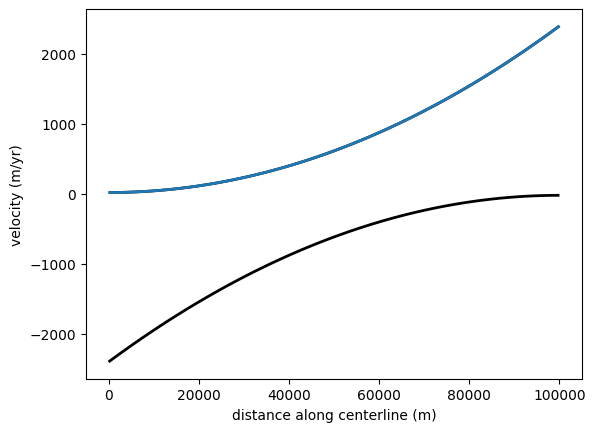

In [7]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("velocity (m/yr)")

firedrake.plot(icepack.depth_average(u0_l), edgecolor="black", axes=axes);
firedrake.plot(icepack.depth_average(u0_r), edgecolor="black", axes=axes);

firedrake.plot(icepack.depth_average(u0), edgecolor="tab:blue", axes=axes);

Set up icepack values.

water pressure = water density * gravity * amount of ice under the water line (elevation = 0)
ice pressure = ice density * gravity * ice height
phi = ramping function for friction.
- If no water pressure, then phi = 1.
- If ice pressure equals water pressure, then phi = 0.

In [8]:
Temperature = firedrake.Constant(255.0) # -18 deg C
A = icepack.rate_factor(Temperature)

# What is C? Is this defining a boundary condition?
C = firedrake.interpolate((0.95 - 0.05 * x/Lx) * tau_D / u_in ** (1/weertman), Q)

p_water = rho_water * g * max_value(0, h0 - s0) 
p_ice = rho_ice * g * h0
#phi = 1 - p_water / max_value(p_ice, p_water) ##### This is the start of issues if h = 0
phi = 1

Set up the icepack model.

In [9]:
import icepack.models.hybrid

def friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    # Update pressures
    p_water = rho_water * g * firedrake.max_value(0, h - s)
    p_ice = rho_ice * g * h
    # phi = 1 - p_water / max_value(p_ice, p_water)
    phi = 1
    return icepack.models.hybrid.bed_friction(
        velocity = u,
        friction = C * phi,
    )

Set up hybrid model solver with custom friction function and initialize the velocity field.

In [10]:
model = icepack.models.HybridModel(friction = friction)
opts = {
    "dirichlet_ids": [1],
    #"diagnostic_solver_type": "petsc",
    #"diagnostic_solver_parameters": {"snes_type": "newtontr"},
}

solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity = u0,
    thickness = h0,
    surface = s0,
    fluidity = A,
    friction = C,
)

Plot new initial velocities.

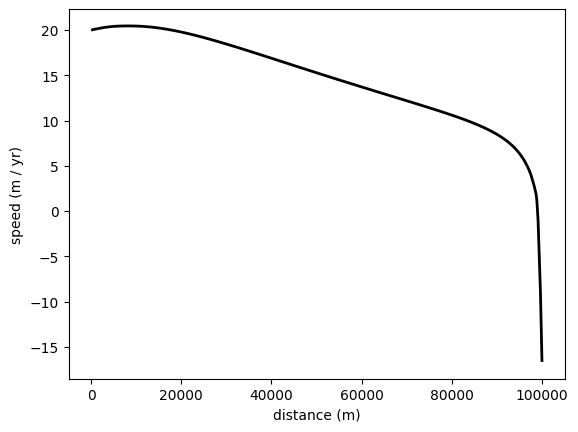

In [11]:
fig, axes = plt.subplots()
axes.set_xlabel("distance (m)")
axes.set_ylabel("speed (m / yr)")
firedrake.plot(icepack.depth_average(u0), axes=axes);

### Run the actual model

In [12]:
h_min = 10
h_calving = 50
cal_step = h_calving - h_min


In [13]:
import tqdm

num_years = 250
timesteps_per_year = 2

dt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.interpolate(1.7 - 4.7 * x / Lx, Q) # Ramping accumulation along length
h = h0.copy(deepcopy = True)
u = u0.copy(deepcopy = True)

height_min1 = np.zeros(num_timesteps) * np.nan
height_min2 = np.zeros(num_timesteps) * np.nan

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness = h,
        velocity = u,
        accumulation = a,
        thickness_inflow = h0,
    )

    height_min1[step] = h.dat.data_ro.min()

    h = icepack.interpolate(conditional(lt(h,h_calving),h_min,h),Q) # Calving to minimum stable value (use UFL for functions)

    # smooth_h = icepack.interpolate(1-(h-h_min)/cal_step,Q)
    # h = icepack.interpolate(conditional(lt(h,h_calving),(3*smooth_h**2-2*smooth_h**3)*cal_step+h_min,h),Q)
    # h = icepack.interpolate(max_value(h,h_min),Q) # Minimum value for stability
    
    s = icepack.compute_surface(thickness=h, bed=b)

    u = solver.diagnostic_solve(
        velocity = u,
        thickness = h,
        surface = s,
        fluidity = A,
        friction = C,
    )

    height_min2[step] = h.dat.data_ro.min()

100%|█████████████████████████████████████████| 500/500 [01:02<00:00,  8.00it/s]


Plot profile.

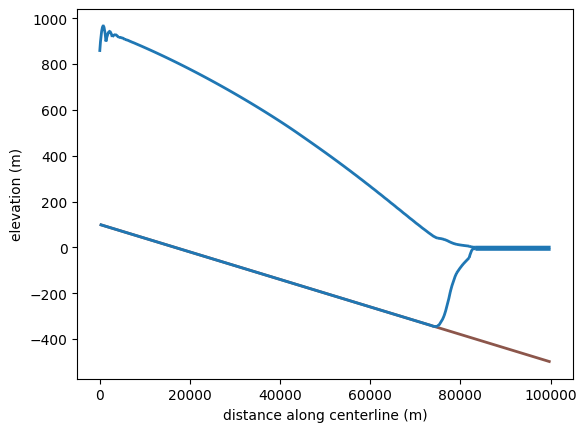

In [14]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("elevation (m)")

firedrake.plot(icepack.depth_average(b), edgecolor="tab:brown", axes=axes)
zb = firedrake.interpolate(s-h, Q)
firedrake.plot(icepack.depth_average(zb), edgecolor="tab:blue", axes = axes)
firedrake.plot(icepack.depth_average(s), edgecolor="tab:blue", axes = axes);

NameError: name 'smooth_h' is not defined

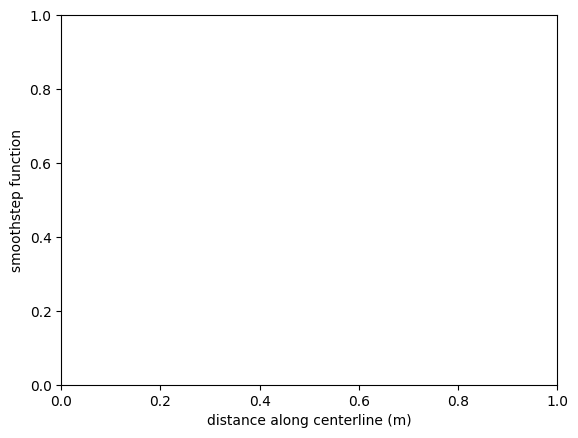

In [15]:
fig, axes = plt.subplots()
axes.set_xlabel("distance along centerline (m)")
axes.set_ylabel("smoothstep function")
firedrake.plot(icepack.depth_average(smooth_h), edgecolor="tab:blue", axes = axes);

In [ ]:
print(height_min1)

In [ ]:
print(height_min2)